In [226]:
from dotenv import load_dotenv
import os
load_dotenv()
API_KEY = os.environ.get("API_KEY")
SECRET_KEY = os.environ.get("SECRET_KEY")


In [227]:
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [259]:

client = StockHistoricalDataClient(API_KEY, SECRET_KEY)

# Define date range
end_date = datetime.now()
start_date = end_date - timedelta(days= 252)  

# Get historical daily data for NVDA and AMD
request = StockBarsRequest(
    symbol_or_symbols=["NVDA", "AMD"],
    timeframe=TimeFrame.Day,
    start=start_date,
    end=end_date
)

# Fetch data
bars = client.get_stock_bars(request)

df = bars.df.reset_index()
df = df.pivot(index="timestamp", columns="symbol", values="close")
print(df)


symbol                        AMD    NVDA
timestamp                                
2024-12-09 05:00:00+00:00  130.87  138.81
2024-12-10 05:00:00+00:00  127.74  135.07
2024-12-11 05:00:00+00:00  130.15  139.31
2024-12-12 05:00:00+00:00  130.60  137.34
2024-12-13 05:00:00+00:00  126.91  134.25
...                           ...     ...
2025-08-11 04:00:00+00:00  172.28  182.06
2025-08-12 04:00:00+00:00  174.95  183.16
2025-08-13 04:00:00+00:00  184.42  181.59
2025-08-14 04:00:00+00:00  180.95  182.02
2025-08-15 04:00:00+00:00  177.51  180.45

[171 rows x 2 columns]


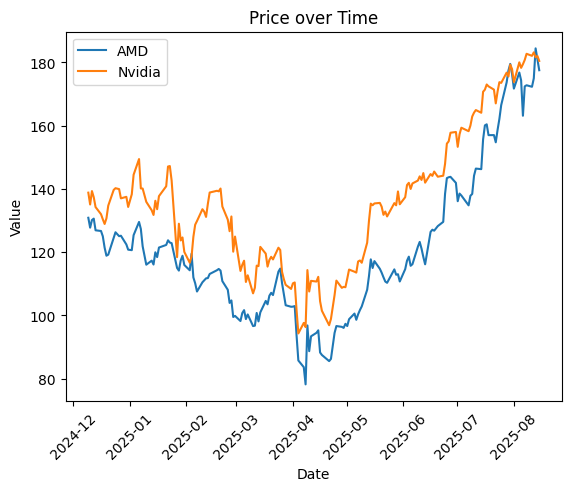

In [260]:
# Plot prices over time
plt.plot(df.index, df['AMD'], label='AMD')
plt.plot(df.index, df['NVDA'], label='Nvidia')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Price over Time')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [230]:
print(df.corr())

symbol      AMD     NVDA
symbol                  
AMD     1.00000  0.95989
NVDA    0.95989  1.00000


In [231]:
# Since assets can be highly correlated and still diverge, we will use a stronger statistical measure, called cointegration
import statsmodels.tsa.stattools as ts 
result = ts.coint(df['AMD'], df['NVDA'])
p_val = result[1]
if p_val < 0.05:
    print(f"With a p value of {round(p_val,4)}, we can reject the null hypothesis and conclude the assets are cointegrated.")
else:
    print(f"With a p value of {round(p_val,4)}, we cannot reject the null hypothesis and conclude the assets are not cointegrated.")



With a p value of 0.0299, we can reject the null hypothesis and conclude the assets are cointegrated.


In [261]:
# Next we will calculate the spread using OLS
import statsmodels.api as sm

Y = df['NVDA']
X = df['AMD']

# Add constant term for regression
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

# Get hedge ratio (slope)
hedge_ratio = model.params['AMD']

print(f"Hedge Ratio: {hedge_ratio}")

spread = df['NVDA'] - hedge_ratio * df['AMD']


Hedge Ratio: 0.8986935310199106


In [233]:
# In order to work with means that aren't meaningless, we must determine whether our spread is stationary or not
from statsmodels.tsa.stattools import adfuller

result = adfuller(spread)
p_val = result[1]
if p_val < 0.05:
    print(f"With a p value of {round(p_val,4)}, we can reject the null hypothesis and conclude the spread is likely stationary.")
else:
    print(f"With a p value of {round(p_val,4)}, we cannot reject the null hypothesis and conclude the spread is likely not stationary.")


With a p value of 0.0043, we can reject the null hypothesis and conclude the spread is likely stationary.


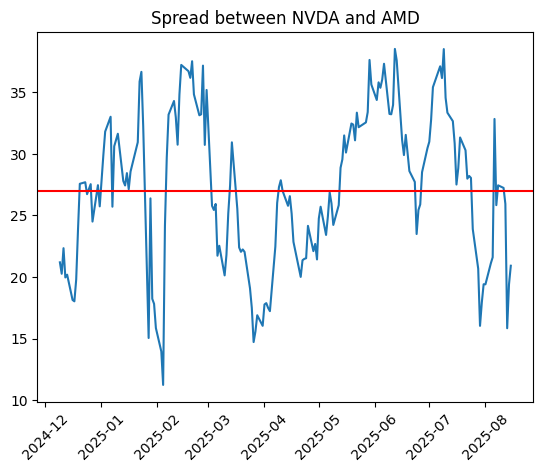

In [262]:
# Plot the spread over time
plt.plot(df.index, spread, label = 'Spread (NVDA - AMD)')
plt.axhline(spread.mean(), color='red')
plt.title("Spread between NVDA and AMD")
plt.xticks(rotation=45)
plt.show()

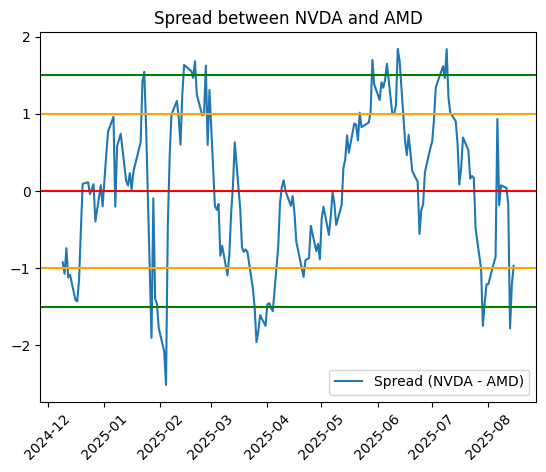

In [235]:
# Next, we will standardize the spread so that the mean is 0 and the standard deviation is 1
# As we can see, if the spread deviates past 1 standard deviation from the mean, it is likely to soon revert back to the mean
spread_normalized = (spread - spread.mean()) / spread.std()
plt.plot(df.index, spread_normalized, label = 'Spread (NVDA - AMD)')
plt.axhline(1, color='orange')
plt.axhline(1.5, color='green')

plt.axhline(0, color='red')
plt.axhline(-1, color='orange')
plt.axhline(-1.5, color='green')
plt.title("Spread between NVDA and AMD")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [256]:
# Smooth the spread over last 3 days average
spread_3_mean = spread.rolling(3).mean()
# Since we can't know the future means and stds, we will use the last 60 days
spread_60_mean = spread.rolling(60).mean()
spread_60_std = spread.rolling(60).std()

# We will use the smoothed z score to enter a position, and the raw z score to exit
z_score_60_5 = (spread_3_mean - spread_60_mean) / spread_60_std
z_score_raw = (spread - spread_60_mean) / spread_60_std


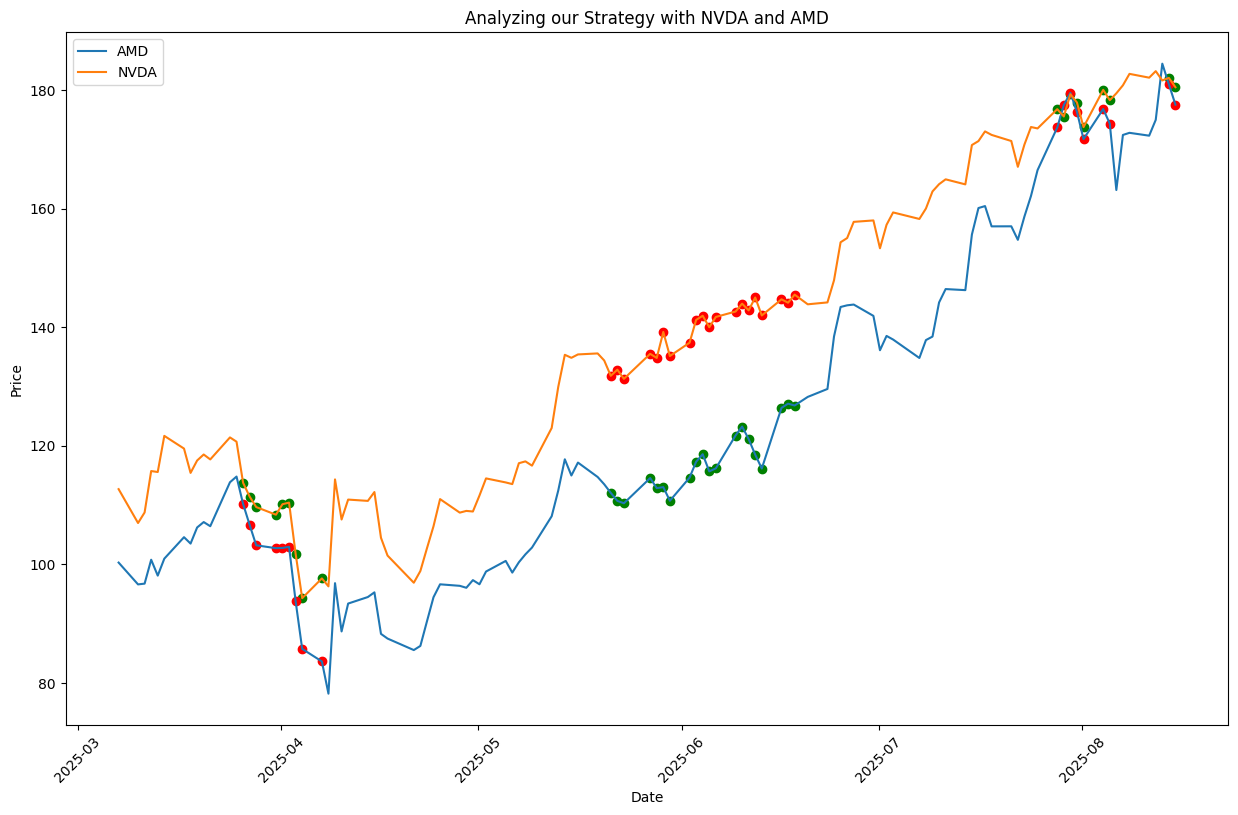

In [ ]:
z_score_5 = pd.DataFrame(z_score_60_5, columns=['zscore_smoothed'])
z_score_raw = pd.DataFrame(z_score_raw, columns=['zscore_raw'])


trades = pd.merge(z_score_5, z_score_raw, left_index=True, right_index=True)
trades = trades[trades['zscore_smoothed'].notnull()]

# Define a trading strategy (Long = 1, Short = -1, Flat = 0)
upper_band = 1.5
lower_band = -1.5
exit_band = 0.3

trades['longs'] = trades['zscore_smoothed'] < lower_band
trades['shorts'] = trades['zscore_smoothed'] > upper_band

trades['long_exit_candidate'] = trades['zscore_raw'] >= -exit_band
trades['short_exit_candidate'] = trades['zscore_raw'] <= exit_band

trades['position'] = 0  

# Determine when to exit
for i in range(1, len(trades)):
    prev_pos = trades['position'].iat[i-1] 
    
    if prev_pos == 0:
        # Enter trades
        if trades['longs'].iat[i]:
            trades['position'].iat[i] = 1
        elif trades['shorts'].iat[i]:
            trades['position'].iat[i] = -1
        else:
            trades['position'].iat[i] = 0
    elif prev_pos == 1:
        # Long: exit if candidate is True
        trades['position'].iat[i] = 0 if trades['long_exit_candidate'].iat[i] else 1
    elif prev_pos == -1:
        # Short: exit if candidate is True
        trades['position'].iat[i] = 0 if trades['short_exit_candidate'].iat[i] else -1

trades['pos_change'] = trades['position'].diff()
trades = pd.merge(trades, df, how = 'left', left_index=True, right_index=True)

longs = trades[trades['position'] == 1]
shorts = trades[trades['position'] == -1]

# Plot our strategy (green = long, red = short)

plt.figure(figsize=(15,9))
plt.plot(trades.index, trades['AMD'], label='AMD')
plt.plot(trades.index, trades['NVDA'], label='NVDA')

plt.scatter(longs.index, longs['NVDA'], color='green')
plt.scatter(shorts.index, shorts['NVDA'], color='red')

plt.scatter(longs.index, longs['AMD'], color='red')
plt.scatter(shorts.index, shorts['AMD'], color='green')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Analyzing our Strategy with NVDA and AMD')
plt.xticks(rotation=45)
plt.legend()
plt.show()



In [258]:

profits = trades.copy()
profits['spread'] = profits['NVDA'] - (hedge_ratio * profits['AMD'])

# Get AMD and NVDA returns
profits['NVDA_returns'] = profits['NVDA'].pct_change()
profits['AMD_returns'] = profits['AMD'].pct_change()

# Get the returns for our strategy
profits['strategy_returns'] = profits['position'].shift(1) * (profits['NVDA_returns'] - hedge_ratio * profits['AMD_returns'])

# Calculate cumulative returns
profits['cum_returns'] = (1 + profits['strategy_returns']).cumprod() - 1

# Calcuate Annual Sharpe Ratio
daily_risk_free = 0.02/252
profits['strategy_excess_returns'] = profits['strategy_returns'] - daily_risk_free

daily_sharpe = profits['strategy_excess_returns'].mean() / profits['strategy_excess_returns'].std()
annual_sharpe = daily_sharpe * 252 ** 0.5
print(f"Annual Sharpe Ratio: {round(annual_sharpe, 2)}")

last_cum_return = profits['cum_returns'].iloc[-1]
print(f"Cumulative return over {len(profits)} days: {round(last_cum_return * 100, 2)}%") 

Annual Sharpe Ratio: 2.64
Cumulative return over 112 days: 27.66%


### Final Thoughts
Remember, we are testing this strategy on historical data that we know is stationary, so the results may be a bit inflated. However, we have seen that this can be a profitable trading strategy going forward. The next step would be to build a model that detects when the spread is no longer stationary.
Aditionally, we are not taking transaction costs into consideration, which would decrease returns by a small amount.